In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [3]:
import numpy as np
import data_loader
import config
import pmcx
from matplotlib import pyplot as plt
from mcs_function import SimulationAttenuation

In [4]:
pmcx.gpuinfo()

[{'name': 'Quadro RTX 8000',
  'id': 1,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 2,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 3,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 4,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedme

In [5]:
config.gpuid

2

In [6]:
config.mcs_func_path

PosixPath('/home/leon_ivan/data/mcs_function_data/function_data.npz')

In [7]:
mu_s_bounds = np.concatenate((
    data_loader.DataLoader.mu_s_red_func_gray_matter(np.array([450, 1000])) / 10 / (1-0.85),
    data_loader.DataLoader.mu_s_red_func_blood_vessel(np.array([450, 1000])) / 10 / (1-0.935)
))
print(mu_s_bounds)

[37.66290306  3.19659229 36.28350788 21.42049621]


In [8]:
mu_s_vals = np.linspace(1, 50, 26)
print(mu_s_vals)

[ 1.    2.96  4.92  6.88  8.84 10.8  12.76 14.72 16.68 18.64 20.6  22.56
 24.52 26.48 28.44 30.4  32.36 34.32 36.28 38.24 40.2  42.16 44.12 46.08
 48.04 50.  ]


In [9]:
g_combined = 0.8675
refractive_index_combined = 1.38

In [10]:
# very deep tissue necessary, since no absorption allows photons to go deep into tissue
# for faster and statiscally better results, increasy voxel size
vol = np.ones((50, 50, 1000))
prop = np.array([[0, 0, 1, 1], [0, 0, g_combined, refractive_index_combined]])
unitinmm = 10

cfg = {
    "nphoton": 1e6, # keep nphotons relatively low, to limit memory of stored data
    "maxdetphoton": 1e6,
    "unitinmm": unitinmm,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop":prop,
    "bc": "ccrcca001000", # mark z=0 plane as detector
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dps", # detector id, path length, scatter count
    "flog": config.mcs_func_path / "log.txt",
}

In [11]:
function_data = []
function_data.append(cfg["nphoton"])
function_data.append(mu_s_vals)

In [ ]:
for i, mu_s in enumerate(mu_s_vals):
    cfg["prop"][1, 1] = mu_s
    cfg["prop"][1, 0] = 0
    cfg["prop"][1, 2] = g_combined
    cfg["prop"][1, 3] = refractive_index_combined
    print(f"Iteration {i}/{len(mu_s_vals)}")
    res = pmcx.mcxlab(cfg)
    cur_photon_data = np.row_stack(
        (
            res["detp"]["ppath"][:, 0],
            res["detp"]["nscat"][:, 0]
        )
    )
    print(f"Mean path length: {pmcx.utils.meanpath(res['detp'])}")
    function_data.append(cur_photon_data)
    # save incrementally to avoid much data loss
    np.savez(config.mcs_func_path, *function_data)

Load Data and plot for some mu_a values

In [14]:
function_data_loaded = np.load(config.mcs_func_path)
nphoton = function_data_loaded["arr_0"]
mu_s_vals = function_data_loaded["arr_1"]

In [25]:
mu_a_bounds = np.concatenate((
    data_loader.DataLoader.mu_a_func_gray_matter(np.array([450, 999])) / 10,
    data_loader.DataLoader.mu_a_func_blood_vessel(np.array([450, 999])) / 10 
))
print(mu_a_bounds)
mu_a_samples = np.linspace(np.min(mu_a_bounds) * 0.75, np.max(mu_a_bounds) * 1.25, 5)

[ 1.25481269  0.05144159 33.45335805  0.54518055]


Text(0, 0.5, 'Attenuation')

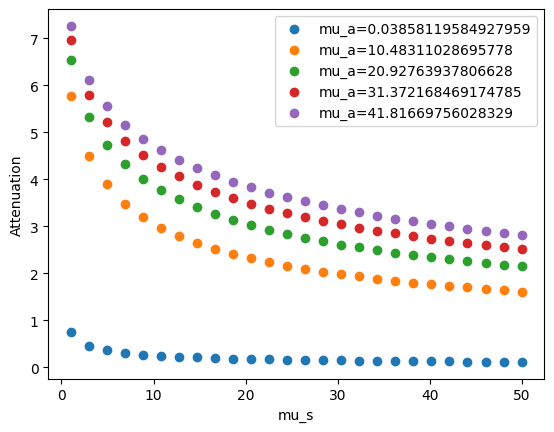

In [26]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 2}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)

    plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")


Same plot but with randomly sampled, then interpolated values for mu_s...

In [27]:
mcs_obj = SimulationAttenuation(config.mcs_func_path)

Text(0, 0.5, 'Attenuation')

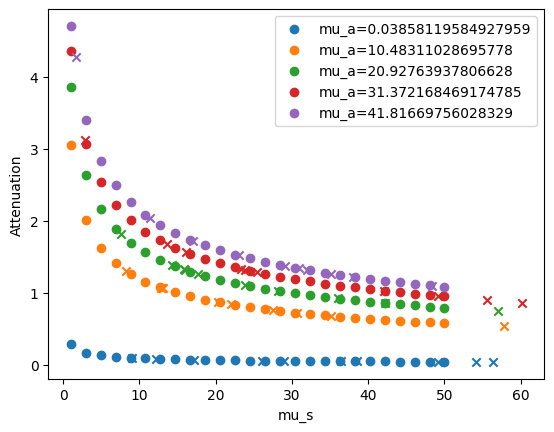

In [30]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 2}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath / 10)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)
    
    p = plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")

    mu_s_vals_sampled = np.random.rand(10) * (mu_s_vals[-1] - mu_s_vals[0]) * 1.25 + mu_s_vals[0]
    attenuation_interpolated =  mcs_obj.A(mu_a, mu_s_vals_sampled)
    plt.scatter(mu_s_vals_sampled, attenuation_interpolated, marker="x", color=p.get_facecolor()[0])

    
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")

Sampe graph, but compare with attenuation based on perturbation Monte Carlo method, with mean mu_a, mu_s values as baseline.
This barely works because of overflows.

In [50]:
mu_a_baseline = mu_a_samples[len(mu_a_samples)//2]
mu_s_baseline = mu_s_vals[-1]
photon_ppath_baseline, photon_nscat_baseline = function_data_loaded[f"arr_{2 + len(mu_s_vals) - 1}"][:, :]
weights_baseline = np.exp(-mu_a_baseline * photon_ppath_baseline)

In [51]:
np.min(photon_nscat_baseline)

1.0

/tmp/ipykernel_2208934/1064740009.py:16: RuntimeWarning: overflow encountered in exp
  photon_weights_perturbed *= np.exp(-(mu_s_vals_sampled - mu_s_baseline)[:, None] * photon_ppath_baseline[None, :])
/tmp/ipykernel_2208934/1064740009.py:16: RuntimeWarning: invalid value encountered in multiply
  photon_weights_perturbed *= np.exp(-(mu_s_vals_sampled - mu_s_baseline)[:, None] * photon_ppath_baseline[None, :])
/tmp/ipykernel_2208934/1064740009.py:17: RuntimeWarning: overflow encountered in exp
  photon_weights_perturbed *= np.exp(-(mu_a - mu_a_baseline) * photon_ppath_baseline[None, :])
/tmp/ipykernel_2208934/1064740009.py:17: RuntimeWarning: invalid value encountered in multiply
  photon_weights_perturbed *= np.exp(-(mu_a - mu_a_baseline) * photon_ppath_baseline[None, :])


Text(0, 0.5, 'Attenuation')

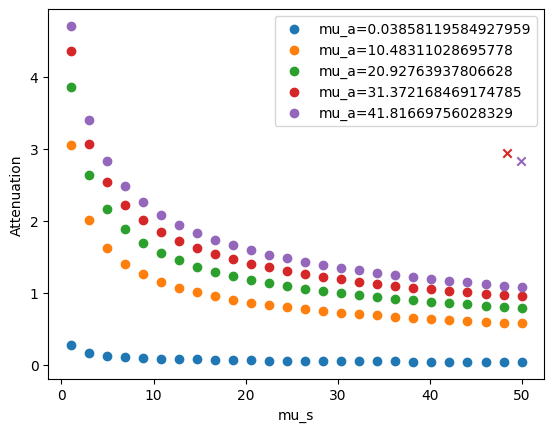

In [53]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    attenuation_per_mu_a_perturbed = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 2}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath / 10)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)

    p = plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")

    mu_s_vals_sampled = np.random.rand(10) * (mu_s_vals[-1] - mu_s_vals[0]) + mu_s_vals[0]
    photon_weights_perturbed = weights_baseline * np.power((mu_s_vals_sampled/mu_s_baseline)[:, None], photon_nscat_baseline[None, :])
    photon_weights_perturbed *= np.exp(-(mu_s_vals_sampled - mu_s_baseline)[:, None] * photon_ppath_baseline[None, :])
    photon_weights_perturbed *= np.exp(-(mu_a - mu_a_baseline) * photon_ppath_baseline[None, :])
    attenuation_perturbed = -np.log(np.sum(photon_weights_perturbed, axis=-1) / nphoton)

    plt.scatter(mu_s_vals_sampled, attenuation_perturbed, marker="x", color=p.get_facecolor()[0])

    
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")

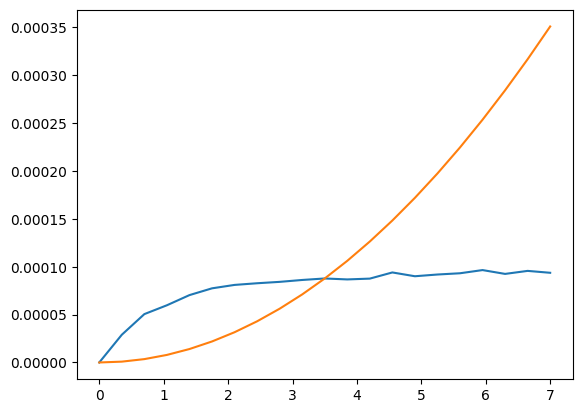

In [134]:
plt.plot(mu_s_vals, dref2)

mu_s_ref = mu_s_vals[len(mu_s_vals) // 2]
k = -mu_s_vals / mu_s_ref
dref_ref = dref2[len(mu_s_vals) // 2]
plt.plot(mu_s_vals, k**2 * dref_ref)

array([10])